# Lab exercise #4: Convolution likelihoods, convolution kernels and SM kernels 

CS-E4075 2021

## Learning objectives

After completing this lab exercise, you should be able to:

- Apply a GP model to a deconvolution problem.
- Using GPflow implement a convolutional kernel within a sparse variational gaussian process model (SVGP)
- Implement spectral mixture kernels in GPflow

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf

tf.executing_eagerly()
import tensorflow_probability as tfp

from gpflow import set_trainable
from gpflow.utilities import to_default_float, positive


gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")

# for reproducibility of this notebook:
np.random.seed(123)


     |████████████████████████████████| 256kB 5.5MB/s 


## Convolutional likelihood models.

In [4]:
import scipy.integrate as integrate
##https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html##

np.random.seed(111)

n = 100
magnSigma2 = .5
ell = .5
sigma2 = 0.001
x = np.linspace(-2,2,n)

f =  lambda t: np.exp(-(2*t)**2)

def g(t):
    bool1 = t > -0.5
    bool2 = t < 0.5 
    return bool1*bool2*1


## Task 1a: Use the scipy numerical integration function to compute the convolution.
-  plot g, f and f_conv.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  


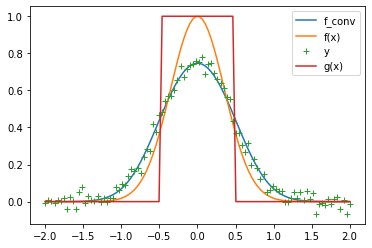

In [156]:
# we now sample noisy data from the convolution function
def covolution(tau, t):
    return f(tau) * g(t-tau)

def epint(t):
    return integrate.quad(covolution, -2, 2, args=(t))[0]

vec_expint = np.vectorize(epint)
f_conv = vec_expint(x)

y = f_conv + np.sqrt(sigma2)*np.random.normal(size=n);

plt.figure()
plt.plot(x,f_conv, label='f_conv')
plt.plot(x,f(x), label='f(x)')
plt.plot(x,y,'+',label='y')
plt.plot(x, g(x), label='g(x)')
plt.legend()
plt.show()

## Task 1b: Compute a discrete convolution.
- Use the discrete grid (x) as above and turn the integral in to a sum. (writing this out on paper may help)
- Output a Convolution matrix which acts as the linear operator on the vector f, $f_{conv} = Cf $. 
- Plot the convolved f together with the discrete version.

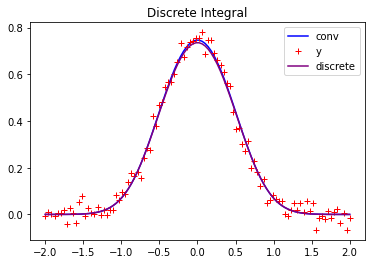

In [179]:
func = lambda t, tau: f(tau)*g(t-tau)
interval = (x[-1] - x[1])/n

discrete = np.zeros(n)
C = np.zeros((n,n))

for i, point in enumerate(x):
    res = 0
    # calculate Riemann integral
    ft = f(point)
    for j, tau in enumerate(x):
        f_res = f(tau)
        g_res = g(point - tau)
        height = f_res * g_res
        area =  height * interval
        # weight of convolution matrix C      
        C[i,j] = area
        res = res + area
    C[i] = C[i] / res
    discrete[i] = res

plt.figure()
plt.title("Discrete Integral")
plt.plot(x,f_conv, label='conv',color='blue')
plt.plot(x,y,'+',label='y',color='red');
plt.plot(x,discrete, label='discrete',color='purple')
plt.legend()
plt.show()

## Task 1c: Now solve the deconvolution problem.
- Follow the adjusted GP regression formula's from the lecture slides using an SE kernel and the C you have calculated.
- Plot the true underlying function alongside with the mean and 95% confidence interval, as shown on slide 30.

In [164]:
assert C.shape == (n,n)

def kernel_matrix(X1, X2, alpha=0.5, scale=0.5):
    matrix = np.zeros((X1.shape[0],X2.shape[0]), dtype=float)
    for x1_idx, x1 in enumerate(X1):
        for x2_idx, x2 in enumerate(X2):
            norms = np.sum((x1-x2)**2)
            matrix[x1_idx][x2_idx] = alpha*np.exp(-0.5*norms/scale**2)
            # norms = np.sum((x1-x2)**2)
            # matrix[x1_idx][x2_idx] = alpha * np.exp(-0.5 * norms/(scale**2))
    return matrix

def kernel(X1, X2, alpha=0.5, scale=0.5):
    # norms = np.sum((X1-X2)**2)
    # return alpha * np.exp(-0.5 * norms/(scale**2))
    norms = np.sum((x1-x2)**2)
    return alpha*np.exp(-0.5*norms/scale**2)


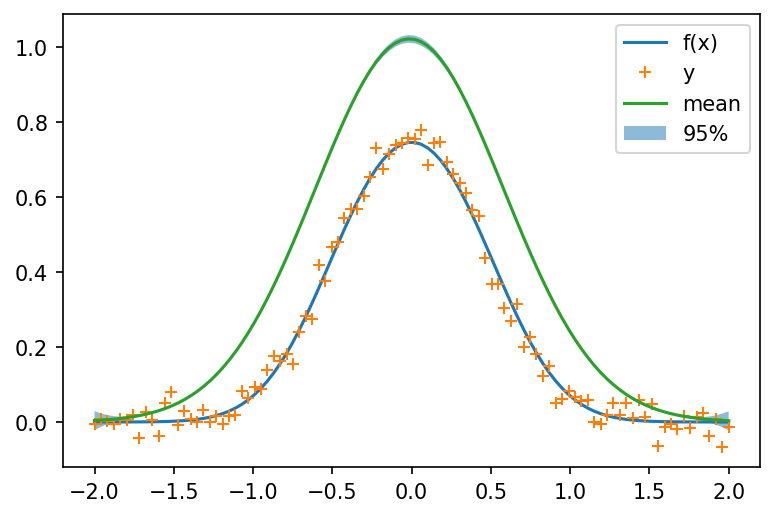

In [180]:
# calculate original rbf kernel covariance matrix
K_original_matrix = kernel_matrix(x,x,0.5, 0.5)
assert K_original_matrix.shape == C.shape == (n,n)

# calcualate covolution kernel matrix K
K = C.dot(K_original_matrix).dot(C.T)
assert K.shape == (n,n)

# K + Sigma2*I
inv_K = np.linalg.inv(K + magnSigma2 * np.eye(n))
assert inv_K.shape == (n,n)

k_t = K_original_matrix.dot(C.T)
E = k_t.dot(inv_K).dot(y)
V = K_original_matrix - k_t.dot(inv_K).dot(k_t)

assert E.shape == (n,)
assert V.shape == (n,n)

upper = []
lower = []

for i in range(n):
    upper.append(E[i] + V_diag[i] * 0.95 / 2)
    lower.append(E[i] - V_diag[i] * 0.95 / 2)

plt.figure(dpi=150)
plt.plot(x,f_conv, label='f(x)')
plt.plot(x,y,'+',label='y');
plt.plot(x, E, label='mean')
plt.fill_between(x,upper,lower,label='95%',alpha=0.5)
plt.legend()
plt.show()

## Convolutional kernel.

We follow the example https://gpflow.readthedocs.io/en/master/notebooks/advanced/convolutional.html

In [78]:
# for reproducibility of this notebook:
np.random.seed(123)
tf.random.set_seed(42)

def make_rectangle(arr, x0, y0, x1, y1):
    # Draw the edges
    arr[y0:y1, x0] = 1
    arr[y0:y1, x1] = 1
    arr[y0, x0:x1] = 1
    arr[y1, x0 : x1 + 1] = 1


def make_random_rectangle(arr):
    # Randomnly initialise the corners
    x0 = np.random.randint(1, arr.shape[1] - 3)
    y0 = np.random.randint(1, arr.shape[0] - 3)
    x1 = np.random.randint(x0 + 2, arr.shape[1] - 1)
    y1 = np.random.randint(y0 + 2, arr.shape[0] - 1)
    make_rectangle(arr, x0, y0, x1, y1)
    return x0, y0, x1, y1


def make_rectangles_dataset(num, w, h):
    # Generate the rectangle dataset
    d, Y = np.zeros((num, h, w)), np.zeros((num, 1))
    for i, img in enumerate(d):
        for j in range(1000):  # Finite number of tries to ensure 
            x0, y0, x1, y1 = make_random_rectangle(img)
            rw, rh = y1 - y0, x1 - x0
            if rw == rh:
                img[:, :] = 0
                continue
            Y[i, 0] = rw > rh
            break
    return (
        d.reshape(num, w * h).astype(gpflow.config.default_float()),
        Y.astype(gpflow.config.default_float()),
    )

In [77]:
MAXITER = 100
NUM_TRAIN_DATA = 100
NUM_TEST_DATA = 300

H = W = 14  # width and height of the images.
IMAGE_SHAPE = [H, W]

X, Y = data = make_rectangles_dataset(NUM_TRAIN_DATA, *IMAGE_SHAPE)
Xt, Yt = test_data = make_rectangles_dataset(NUM_TEST_DATA, *IMAGE_SHAPE)

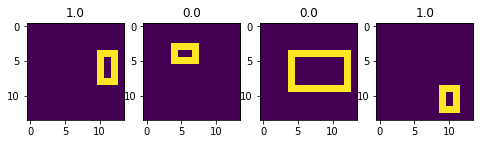

In [79]:
plt.figure(figsize=(8, 3))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i, :].reshape(*IMAGE_SHAPE))
    plt.title(Y[i, 0])

Each image contains the outline of a randomly generated rectangle, and is labelled according
to whether the rectangle has larger width or height. $y_i = 1$ if height is greater than width and $y_i = 0$ if width is greater than height.

## Task 2a: Comment on why a standard kernel would struggle with the rectangle dataset?

The standard kernel does not work well with rectangle dataset because:
1. The input data contains high dimensionality
2. Strong dependence of the label on multiple pixel locations

Source - Mark et. al. Convolutional Gaussian Processes. arXiv:1709.01894v1  [stat.ML]  6 Sep 2017

We now try to fit a squared exponential kernel to the rectangle dataset, using the model class SVGP. SVGP is the sparse version of VGP discussed in lecture 4.

In [36]:
# This is a standard initialisation of the SVGP model class we need a kernel, 
# likelihood and inducing point locations.
rbf_m = gpflow.models.SVGP(
    gpflow.kernels.SquaredExponential(),
    gpflow.likelihoods.Bernoulli(),
    gpflow.inducing_variables.InducingPoints(X.copy()),
)# We use our data points as inducing points but usually you would want to use a sparse set.

In [37]:
# We turn off training for inducing point locations
set_trainable(rbf_m.inducing_variable, False)

# Similar to how we optimised in lab_3 but now using Adam and gradients are called inside optimizer.
def run_adam(model, iterations, data): 
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    training_loss = model.training_loss_closure(data, compile=True)
    optimizer = tf.optimizers.Adam(lr=0.01)

    @tf.function # This creates a static graph so we can reuse it every iteration.
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf


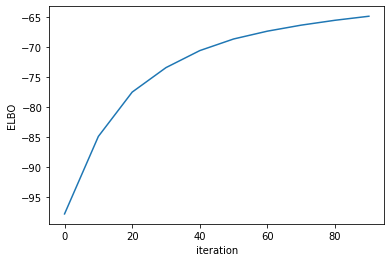

In [38]:
maxiter = 100

logf = run_adam(rbf_m, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [ ]:
train_acc = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")

Train acc: 100.0%
Test acc : 67.66666666666666%


In [ ]:
gpflow.utilities.print_summary(rbf_m) # We can here see all the parameters that we optimise

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.variance,Parameter,Softplus,,True,(),float64,0.7914542018059795
SVGP.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.9023913654461018
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(100, 196)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(100, 1)",float64,[[0.54583751...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 100, 100)",float64,"[[[8.46642716e-01, 0.00000000e+00, 0.00000000e+00..."


## Task 2b: Change the number of inducing points in this model?

Currently we are not using a reduced number inducing points $M =N$ and SVGP is the same as VGP. Try picking less but keep them randomnly selected from the data and see the effect on the model. Try $M=75,50,25$ and state the train and test accuracy.

In [42]:
M = [75,50,25]
set_trainable(rbf_m.inducing_variable, True)
idx = np.arange(0,n)

for m in M:
    idx_chosen = np.random.choice(idx, size = m, replace=False)
    logf = run_adam(rbf_m, maxiter,(X[idx_chosen],Y[idx_chosen]))
    train_acc = np.mean((rbf_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
    test_acc = np.mean((rbf_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
    print(f"\nM = {m}")
    print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%\n")
    print('-'*20)


M = 75
Train acc: 92.0%
Test acc : 63.66666666666667%

--------------------

M = 50
Train acc: 89.0%
Test acc : 63.66666666666667%

--------------------

M = 25
Train acc: 54.0%
Test acc : 56.333333333333336%

--------------------


## Conclusion
More inducing points can yield better prediction posterior and higher accuracy on both training set and test set

## Convolutional Kernel
To construct a convolutional GP we use a patch response function $g: \mathbb{R}^E \to \mathbb{R}$ mapping form patch size $E$ to a real value. Then we make the overall function of the image $f: \mathbb{R}^D \to \mathbb{R}$ a sum of the patch functions. If $g(.)$ is given a GP prior then a GP prior is induced on $f(.)$.

$$ g \sim \mathcal{GP}(0,k_g(\bf{z},\bf{z}')), \quad f ({x}) = \sum_{p} g(\bf{x}^{[p]}) $$

$$ f ({x}) \sim \mathcal{GP} \big(0,\sum_{p} \sum_{p'} k_g(\bf{x}^{[p]},\bf{x}'^{[p']}) \big)$$

- The kernel now works on the patches.
- $k_g$ can be any base kernel but we will use the squared exponential

In [80]:
def get_patches(X): # A function that will give us vector patches
        """
        Extracts patches from the images X.
        :param X: (N x input_dim)
        :return: Patches (N, num_patches, patch_shape)
        """

        num_data = tf.shape(X)[0]
        castX = tf.transpose(tf.reshape(X, [num_data, -1, 1]), [0, 2, 1])
        patches = tf.image.extract_patches(
            tf.reshape(castX, [-1, 14, 14, 1], name="rX"),
            [1, 3, 3, 1],
            [1, 1, 1, 1],
            [1, 1, 1, 1],
            "VALID",
        )
        shp = tf.shape(patches)  # img x out_rows x out_cols
        reshaped_patches = tf.reshape(
            patches, [num_data, 1 * shp[1] * shp[2], shp[3]]
        )
        return to_default_float(reshaped_patches)

## Task 2c: Compute a value of the kernel and compare it against the gpflow implementation.

- Do not compute the whole kernel simply K[0,0] will do. Remember to normalise by the total number of sums.
- You can check your solution against the evaluated GPflow kernel.
- Comment on the computation of the convolutional kernel against a standard kernel.

In [102]:
base = gpflow.kernels.SquaredExponential()
Xp = get_patches(X)

def K(Xp):
    num_patches = Xp.shape[1]
    Xp = Xp
    Xp2 = Xp

    bigK = base.K(Xp, Xp2)  # [N, num_patches, N, num_patches]

    weights = np.ones(num_patches)
    W2 = weights[:, None] * weights[None, :]  # [P, P]
    W2bigK = bigK * W2[None, :, None, :]
    return tf.reduce_sum(W2bigK, [1, 3]) / num_patches ** 2

value = K(Xp)


In [103]:
print(value)
# evaluated GPflow kernel
k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, Xp.shape[2])
res = k.K(Xp,Xp)

tf.Tensor(
[[0.73168351 0.72864527 0.54564763 ... 0.65664345 0.68220683 0.5416144 ]
 [0.72864527 0.72733361 0.54471897 ... 0.6536291  0.68152949 0.54228043]
 [0.54564763 0.54471897 0.43285611 ... 0.49775728 0.51608716 0.43158336]
 ...
 [0.65664345 0.6536291  0.49775728 ... 0.59377128 0.61352058 0.49322652]
 [0.68220683 0.68152949 0.51608716 ... 0.61352058 0.64035726 0.51448205]
 [0.5416144  0.54228043 0.43158336 ... 0.49322652 0.51448205 0.43238205]], shape=(100, 100), dtype=float64)


TypeError: ignored

Now we build the SVGP model with the convolution kernel.

In [ ]:

## We constrain our parameters to help with optimisation.
f64 = lambda x: np.array(x, dtype=np.float64)
positive_with_min = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4))(tfp.bijectors.Softplus())
constrained = lambda: tfp.bijectors.AffineScalar(shift=f64(1e-4), scale=f64(100.0))(
    tfp.bijectors.Sigmoid()
)
max_abs_1 = lambda: tfp.bijectors.AffineScalar(shift=f64(-2.0), scale=f64(4.0))(
    tfp.bijectors.Sigmoid()
)

# Build the convolutional kernel given specific image data.
conv_k = gpflow.kernels.Convolutional(gpflow.kernels.SquaredExponential(), IMAGE_SHAPE, patch_shape)
conv_k.base_kernel.lengthscales = gpflow.Parameter(1.0, transform=positive_with_min())

# Weight scale and variance are non-identifiable. We also need to prevent variance from shooting off crazily.
conv_k.base_kernel.variance = gpflow.Parameter(1.0, transform=constrained())
conv_k.weights = gpflow.Parameter(conv_k.weights.numpy(), transform=max_abs_1())
conv_f = gpflow.inducing_variables.InducingPatches(
    np.unique(conv_k.get_patches(X).numpy().reshape(-1, 9), axis=0)
) # We place the inducing variables in the patch space and remove duplicates.


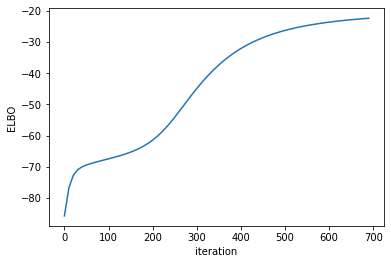

In [ ]:
maxiter = 700

# we now define a new model with the special convolutional kernel structure.
conv_m = gpflow.models.SVGP(conv_k, gpflow.likelihoods.Bernoulli(), conv_f)

set_trainable(conv_m.inducing_variable, False) # for not do not train inducing variables.
set_trainable(conv_m.kernel.base_kernel.variance, True)
set_trainable(conv_m.kernel.weights, True)


logf = run_adam(conv_m, maxiter,(X,Y))
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

In [ ]:
train_acc = np.mean((conv_m.predict_y(X)[0] > 0.5).numpy().astype("float") == Y)
test_acc = np.mean((conv_m.predict_y(Xt)[0] > 0.5).numpy().astype("float") == Yt)
print(f"Train acc: {train_acc * 100}%\nTest acc : {test_acc*100}%")


Train acc: 100.0%
Test acc : 98.33333333333333%


In [ ]:
gpflow.utilities.print_summary(conv_m) # can you spot the difference with the standard SVGP summary.

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.base_kernel.variance,Parameter,Sigmoid + AffineScalar,,True,(),float64,62.711377272119876
SVGP.kernel.base_kernel.lengthscales,Parameter,Softplus + AffineScalar,,True,(),float64,0.6426671133394776
SVGP.kernel.weights,Parameter,Sigmoid + AffineScalar,,True,"(144,)",float64,"[-0.77944789, -0.37365567, -0.2530622..."
SVGP.inducing_variable.Z,Parameter,Identity,,False,"(45, 9)",float64,"[[0., 0., 0...."
SVGP.q_mu,Parameter,Identity,,True,"(45, 1)",float64,[[0.03312427...
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 45, 45)",float64,"[[[0.07696406, 0., 0...."


## Task 2d: Now turn training on for the patches and plot them

# Sprectal mixture kernel

The SM kernel implementation compatible with gpflow. There are several kernels already defined in gpflow.kernels, and they all share the base 'Kernel' class. The kernel computation uses tensorflow functions (not numpy) so that we can utilize autodiff for later optimization.

__Task 3a__: Complete the below SM kernel function to implement 1D Spectral Mixture kernel within the gpflow framework

$$k(x,x') = \sum_{q=1}^Q a_q \exp( -2 \pi^2 \sigma_q^2 \tau^2) \cos( 2 \pi \mu_q \tau), \quad \tau = x-x'$$

that corresponds to a spectral mixture density

$$S(\omega) = \sum_{q=1}^Q a_q \mathcal{N}(\omega | \mu_q, \sigma_q^2)$$

where $a_q$ is the amplitude, $\mu_q$ is the mean frequency and $\sigma_q^2$ is the frequency variance in the frequency $\omega$ domain. For info on implementing gpflow kernels, see https://gpflow.readthedocs.io/en/master/notebooks/tailor/kernel_design.html


Hint: Compute the component-wise kernels into a kernel matrix of size (N,N,Q), and sum them together to obtain (N,N) kernel matrix.

In [113]:

class UnivariateSMkernel(gpflow.kernels.Kernel):
    """
    The spectral mixture (SM) kernel function [Wilson et al 2013]
    
    Inherits the 'Kernel' class from gpflow.kernels
     o We need to override the constructor to include the parameters (a,mu,sigma)
     o We need to override the 'K' function to compute the exp*cos kernel
     o We need to override the 'K_diag' function
     
    Supports only 1D inputs. Wilson et al 2014 contains multivariate version of the kernel 
    """
    
    def __init__(self, amps=None, freqs=None, ells=None, Q=1):
        """
        - 'amps' are the amplitudes of the mixture components 
        - 'freqs' are the frequencies means of the mixture components 
        - 'ells' are the frequency stdevs of the mixture components 
        - 'Q' is the number of components
        """
        
        # init as 1D kernel 
        super().__init__(active_dims=[0]) #input_dim=1

        # mixture amplitudes
        if amps is None:
            amps = np.random.uniform(0,1,Q)
        self.amplitudes = gpflow.Parameter(amps, transform=positive())
        
        # frequency means
        if freqs is None:
            freqs = np.random.uniform(0,1,Q)
        self.frequencies = gpflow.Parameter(freqs, transform=positive())
        
        # frequency variances
        if ells is None:
            ells = np.random.uniform(0,1,Q)
        self.lengthscales = gpflow.Parameter(ells, transform=positive())

        self.Q = Q
        
    def K_diag(self, X):
        return tf.fill(tf.stack([tf.shape(X)[0]]), tf.reduce_sum(self.amplitudes))
    
    def K(self, X1, X2=None):
        """ Returns a kernel matrix of size (N1,N2) where (i,j)'th element is k(xi,xj)
        
        Input: X1 of size (N1,D)
               X2 of size (N2,D)
        """
        if X2 is None:
            X2 = X1
        
        ##############################
        kernel = []

        for x1 in X1:
            tmp = []
            for x2 in X2:
                exp = tf.reduce_sum(tf.math.exp(-2 * (np.pi**2) * (self.lengthscales**2) * ((x1-x2)**2)))
                cos = tf.reduce_sum(tf.math.cos(2 * np.pi * self.frequencies * (x1-x2)))
                res = self.amplitudes*exp*cos
                print(res)
                tmp.append(res)
            kernel.append(tmp)


        ##############################
        
        ##  >>>> SOLUTION CODE BELOW, REMOVE BEFORE GIVING TO STUDENTS <<<<
        
        return kernel

In [105]:
from gpflow.utilities import print_summary, positive
usmk = UnivariateSMkernel()
print_summary(usmk, fmt="notebook")

name,class,transform,prior,trainable,shape,dtype,value
UnivariateSMkernel.amplitudes,Parameter,Softplus,,True,"(1,)",float64,[0.69646919]
UnivariateSMkernel.frequencies,Parameter,Softplus,,True,"(1,)",float64,[0.28613933]
UnivariateSMkernel.lengthscales,Parameter,Softplus,,True,"(1,)",float64,[0.22685145]


__Task 3b__: Fit a trigonometric function using the code below with both Gaussian and SM kernel.

* Why are the fits different outside the training data?

* Which kernel fits the data better, and why?


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.82905
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.117581
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00574529


Tensor("while/while/mul_5:0", shape=(3,), dtype=float64)


ValueError: ignored

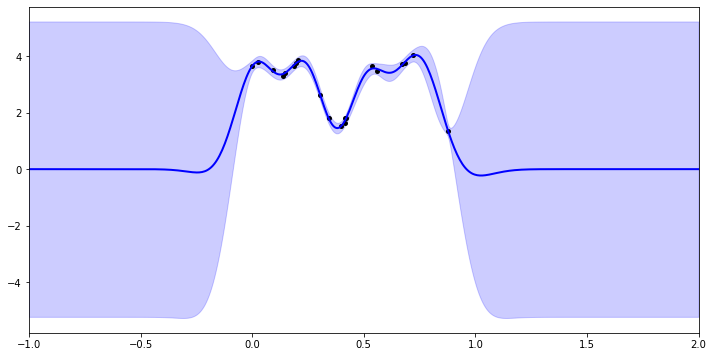

In [114]:
# plotting function    
def plotgp(m, X, y, minx, maxx):
    xx = np.linspace(minx, maxx, 500)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'k.', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(minx, maxx)


opt = gpflow.optimizers.Scipy()

# data
np.random.seed(1)
N = 20
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3

# fit GP fit Gaussian kernel
kgauss = gpflow.kernels.RBF( 1, lengthscales=0.3 )  # init lengthscale to 0.3
mg = gpflow.models.GPR( (X,Y), kernel = kgauss )
mg.likelihood.variance.assign(0.01)
opt.minimize(mg.training_loss, variables=mg.trainable_variables)

# print and plot
gpflow.utilities.print_summary(mg)
plotgp(mg, X, Y, -1, 2)


# fit GP with SM kernel
ksm = UnivariateSMkernel( Q = 3 )
ms = gpflow.models.GPR( (X,Y), kernel = ksm )
ms.likelihood.variance.assign(0.01)
opt.minimize(ms.training_loss, variables=ms.trainable_variables)

# print and plot
gpflow.utilities.print_summary(ms)
plotgp(ms, X, Y, -1, 2)


__Task 3c__ Apply the SM kernel to the CO2 dataset. Below is a template code that (usually) fits the datasets correctly due to initialising the correct 1-year frequency (1/12) for the model. It might take a few retries to find a good fit.

* Modify the code to have a random initialisation of the frequencies. Can you still learn the 1-year frequency if the initialisation is random? Why or whynot?

* Modify the visualisation to include both training and test points. Is the fit reasonable?

* Visualise the optimised SM kernel matrix. What can you see?

* Visualise the spectral density $S(\omega) = \sum_{q=1}^Q a_q \mathcal{N}(\omega | \mu_q, \sigma_q^2)$ using the parameter you just optimised. 



In [ ]:
import sklearn
from sklearn.datasets import fetch_openml

def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    avg_ppmvs = np.asarray(avg_ppmvs).reshape(-1, 1)
    return months, avg_ppmvs


X,Y = load_mauna_loa_atmospheric_co2()

Xtr = X[0:100]
Ytr = Y[0:100]

Xts = X[100:]
Yts = Y[100:]


# set SM kernel model
ksm = UnivariateSMkernel( Q = 3, freqs = [0.083, 1.0, 0.5], ells = [0.01, 0.01, 0.01], amps = [20,20,20] )
#ksm = UnivariateSMkernel( Q = 10 )
m = gpflow.models.GPR( (Xtr,Ytr), kernel = ksm )
m.likelihood.variance.assign(0.1)
set_trainable(m.likelihood.variance, False)

# optimize
opt = gpflow.optimizers.Scipy()
opt.minimize( m.training_loss, variables=m.trainable_variables )

# print
gpflow.utilities.print_summary(m)

# plot
plotgp(m, Xtr, Ytr, 1950., 2020.)


OperatorNotAllowedInGraphError: ignored